In [1]:
#ste width to 100% for widescreen monitor
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import pandas as pd
import numpy as np
from scipy.stats import uniform
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import RobustScaler, StandardScaler, LabelBinarizer
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict, RandomizedSearchCV, GridSearchCV
from sklearn import metrics
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

#import the data
train = pd.read_csv(r'C:\Users\conno\Documents\NW SPS Masters\MSDS 422 - Practical Maching Learning\Module 3\Assignment 3\train.csv')
test = pd.read_csv(r'C:\Users\conno\Documents\NW SPS Masters\MSDS 422 - Practical Maching Learning\Module 3\Assignment 3\test.csv')
sample = pd.read_csv(r'C:\Users\conno\Documents\NW SPS Masters\MSDS 422 - Practical Maching Learning\Module 3\Assignment 3\gender_submission.csv')


#set indexes to PassgenerId
train.set_index('PassengerId', drop = True, inplace = True)
test.set_index('PassengerId', drop = True, inplace = True)



,Survived
Age_Cat,
Infant,0.648649
Child,0.360000
Teenager,0.441558
Young Adult,0.348606
Adult,0.398190
Senior,0.227273


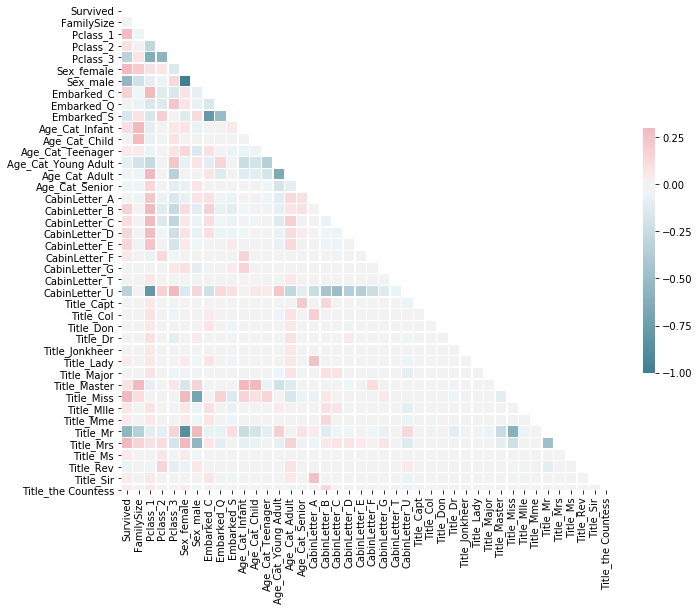

In [315]:
import seaborn as sns
import numpy as np


train2 = train
train2['Pclass'] = train2['Pclass'].apply(str)

#code to set age classes

def define_age_cat(X,buckets,labels):
    X["Age_Cat"] = pd.cut(X["Age"],buckets,labels=labels)
    return X

buckets = [0, 5, 12, 18, 35, 60, 100]
labels = ['Infant', 'Child', 'Teenager', 'Young Adult', 'Adult', 'Senior']
train2 = define_age_cat(train2,buckets,labels)

#Cabin letter
train2['CabinLetter'] = train['Cabin'].str[:1]
train2['CabinLetter'] = train['CabinLetter'].fillna('U')


#Family Size
train2['FamilySize'] = train2['SibSp'] + train2['Parch'] + 1


train2 = train2.drop(columns = ['Name','Cabin','Ticket','Age','SibSp','Parch','Fare'])

#add dummy vars
train2 = pd.get_dummies(train2)


#create correlation heat map
corr = train2.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


#Survival Rate by Age Class
survived = train.groupby(['Age_Cat'])['Survived'].apply(lambda x : x.astype(int).sum())
count = train.groupby(['Age_Cat'])['Survived'].apply(lambda x : x.astype(int).count())
display(pd.DataFrame(survived/count))


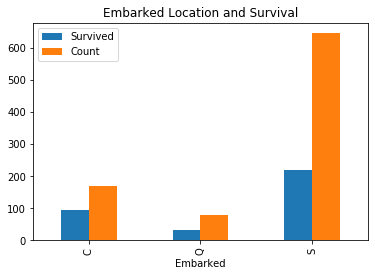

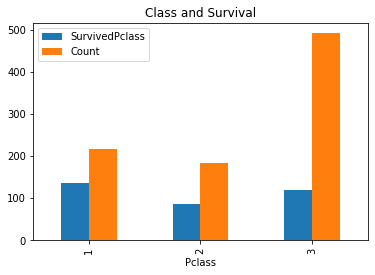

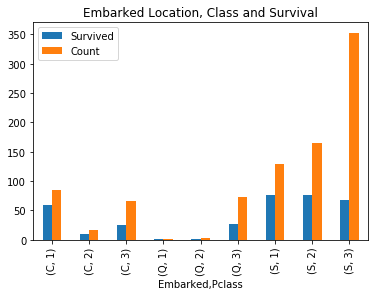

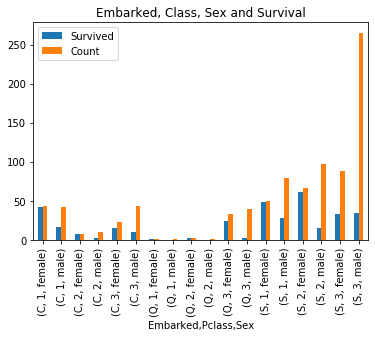

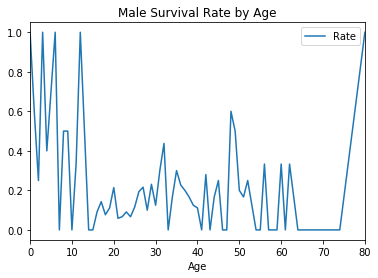

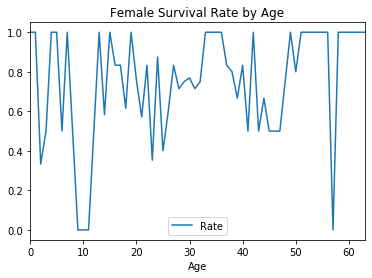

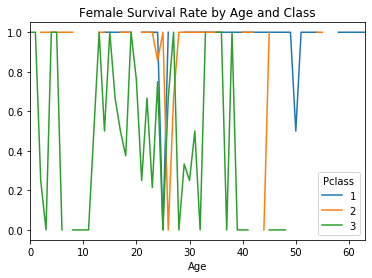

In [311]:

#create family size and plot
#train['FamilySize'] = train['SibSp'] + train['Parch']
#FamilySizecount = train[['FamilySize','Survived']].groupby('FamilySize').count()
#FamilySizesurvived = train[['FamilySize','Survived']].groupby('FamilySize').sum()
#FamilySizesurvived = FamilySizesurvived.join(count, lsuffix = 'FamilySize').rename(columns={'SurvivedFamilySize':'Survived','Survived':'Count'})
#FamilySizesurvived.plot(kind = 'bar')

#plot embarked and survived
Embarkedcount = train[['Embarked','Survived']].groupby('Embarked').count()
Embarkedsurvived = train[['Embarked','Survived']].groupby('Embarked').sum()
Embarkedsurvived = Embarkedsurvived.join(Embarkedcount, lsuffix = 'Embarked').rename(columns={'SurvivedEmbarked':'Survived','Survived':'Count'})
Embarkedsurvived.plot(kind = 'bar', title = 'Embarked Location and Survival')

#plot class and survived
Classcount = train[['Pclass','Survived']].groupby('Pclass').count()
Classsurvived = train[['Pclass','Survived']].groupby('Pclass').sum()
Classsurvived = Classsurvived.join(Classcount, lsuffix = 'Pclass').rename(columns={'SurvivedClass':'Survived','Survived':'Count'})
Classsurvived.plot(kind = 'bar', title = 'Class and Survival')

#plot embarked class and survived
Embarkedcount = train[['Embarked','Pclass','Survived']].groupby(['Embarked','Pclass']).count()
Embarkedsurvived = train[['Embarked','Pclass','Survived']].groupby(['Embarked','Pclass']).sum()
Embarkedsurvived = Embarkedsurvived.join(Embarkedcount, lsuffix = 'Embarked').rename(columns={'SurvivedEmbarked':'Survived','Survived':'Count'})
Embarkedsurvived.plot(kind = 'bar', title = 'Embarked Location, Class and Survival')

#plot embarked class, sex, and survived
Embarkedcount = train[['Embarked','Pclass','Sex','Survived']].groupby(['Embarked','Pclass','Sex']).count()
Embarkedsurvived = train[['Embarked','Pclass','Sex','Survived']].groupby(['Embarked','Pclass','Sex']).sum()
Embarkedsurvived = Embarkedsurvived.join(Embarkedcount, lsuffix = 'Embarked').rename(columns={'SurvivedEmbarked':'Survived','Survived':'Count'})
Embarkedsurvived.plot(kind = 'bar', title = 'Embarked, Class, Sex and Survival')


#set fare NA to 0
cols = ['Fare']
train[cols] = train[cols].fillna(0)

#fill missing Embarked values regarding likely similar characteristics with the mode
cols = ["Embarked"]
train[cols] = train.groupby(['Pclass'])[cols].transform(lambda x: x.fillna(x.mode()[0]))


# fill missing ages with similar Embarked, Pclass, and Sex
cols = ["Age"]
train[cols] = train.groupby(['Embarked','Pclass','Sex'])[cols].transform(lambda x: x.fillna(round(x.median())))
train['Age'] = train['Age'].astype(np.int64)

#male age
ages = train[train['Sex'] == 'male']
ages = ages[['Age','Survived']]
survivalcount = ages.groupby('Age').sum()
count = ages.groupby('Age').count()
survivalcount = survivalcount.join(count,lsuffix = 'Count').rename(columns = {'SurvivedCount':'Survived','Survived':'Count'})
survivalcount['Rate'] = survivalcount['Survived'] / survivalcount['Count']
survivalcount.plot(kind = 'line', y= 'Rate', title = 'Male Survival Rate by Age')

#female age
ages = train[train['Sex'] == 'female']
ages = ages[['Age','Survived']]
survivalcount = ages.groupby('Age').sum()
count = ages.groupby('Age').count()
survivalcount = survivalcount.join(count,lsuffix = 'Count').rename(columns = {'SurvivedCount':'Survived','Survived':'Count'})
survivalcount['Rate'] = survivalcount['Survived'] / survivalcount['Count']
survivalcount.plot(kind = 'line', y= 'Rate', title = 'Female Survival Rate by Age')

#female age
ages = train[train['Sex'] == 'female']
ages = ages[['Age','Survived','Pclass']]
survivalcount = ages.groupby(['Age','Pclass']).sum()
count = ages.groupby(['Age','Pclass']).count()
survivalcount = survivalcount.join(count,lsuffix = 'Count').rename(columns = {'SurvivedCount':'Survived','Survived':'Count'})
survivalcount['Rate'] = survivalcount['Survived'] / survivalcount['Count']
survivalcount.unstack().plot(kind = 'line', y= 'Rate', title = 'Female Survival Rate by Age and Class')


#Analyze Title and Family Size
#train['Title'] = train['Name'].apply(lambda name: name.split(',')[1].split('.')[0].strip())
#train['FamilySize'] = train['SibSp'] + train['Parch'] +1
#FamTitle = train[['FamilySize','Title','Survived']]
#Count = FamTitle.groupby(['Title','FamilySize']).count()
#Survived = FamTitle.groupby(['Title','FamilySize']).sum()
#FamTitle = Survived.join(Count,lsuffix = 'Fam')
#FamTitle['Rate'] = FamTitle['SurvivedFam'] / FamTitle['Survived']
#FamTitle



C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  after removing the cwd from sys.path.


,FamilySize,Sex,Male_15_45,Cabin_BCDE,3_Female_20_35,Fam_GT_4,Class1,Age_Cat_Infant,Age_Cat_Child,Age_Cat_Teenager,Age_Cat_Young Adult,Age_Cat_Adult,Age_Cat_Senior,Title_Capt,Title_Col,Title_Don,Title_Dona,Title_Dr,Title_Jonkheer,Title_Lady,Title_Major,Title_Master,Title_Miss,Title_Mlle,Title_Mme,Title_Mr,Title_Mrs,Title_Ms,Title_Rev,Title_Sir,Title_the Countess
PassengerId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,2,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,2,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,2,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
5,1,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>
Logistic: ROC AUC=0.883
<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>
MNB: ROC AUC=0.836


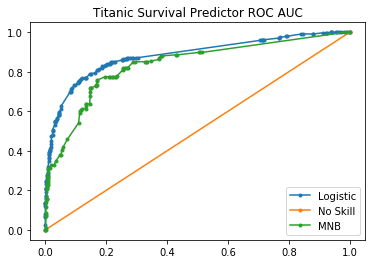

In [320]:
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

X = pd.concat([train.drop('Survived', axis = 1),test])


#Convert Pclass to string
X['Pclass'] = X['Pclass'].apply(str)

#create family size variable
X['FamilySize'] = X['SibSp'] + X['Parch'] +1


#set fare NA to 0
cols = ['Fare']
X[cols] = X[cols].fillna(0)

#extract first letter of cabin and fill na with U
cols = ['Cabin']
X[cols] = X['Cabin'] .str[:1]
X[cols] = X[cols].fillna('U')


#fill missing Embarked values regarding likely similar characteristics with the mode
cols = ["Embarked"]
X[cols] = X.groupby(['Pclass'])[cols].transform(lambda x: x.fillna(x.mode()[0]))


# fill missing ages with similar Embarked, Pclass, and Sex
cols = ["Age"]
X[cols] = X.groupby(['Embarked','Pclass','Sex'])[cols].transform(lambda x: x.fillna(round(x.median())))
X['Age'] = X['Age'].astype(np.int64)


#Get Title from name. Correlation map suggests certain titles could help predict survival
X['Title'] = X['Name'].apply(lambda name: name.split(',')[1].split('.')[0].strip())

#Create 1st class binary var as first class appears to be predictive
X['Class1'] = np.where(X['Pclass'] == '1','yes','no')


#Male 15 - 45. Based on analysis of male age and survival(see line plot)
X['Male_15_45'] = np.logical_and.reduce((X['Sex']=='male', X['Age'] >= 15, X['Age'] <= 45))


#Family count greater or equal to than 4
X['Fam_GT_4'] = np.where(X['FamilySize'] >= 4, 'yes', 'no')


#3rd class female between 20 - 35
X['3_Female_20_35'] = np.logical_and.reduce((X['Sex']=='female', X['Age'] >= 20, X['Age'] <= 45,X['Pclass'] == '3'))


#Cabin B,C,D or E
X['Cabin_BCDE'] = np.logical_or.reduce((X['Cabin']=='B',X['Cabin']=='C', X['Cabin']=='D',X['Cabin']=='E'))

def define_age_cat(X,buckets,labels):
    X["Age_Cat"] = pd.cut(X["Age"],buckets,labels=labels)
    return X

buckets = [0, 5, 12, 18, 35, 60, 100]
labels = ['Infant', 'Child', 'Teenager', 'Young Adult', 'Adult', 'Senior']
X = define_age_cat(X,buckets,labels)




#BinaryEncoding
lb = LabelBinarizer()
X['Sex'] = lb.fit_transform(X['Sex'])
X['Male_15_45'] = lb.fit_transform(X['Male_15_45'])
X['3_Female_20_35'] = lb.fit_transform(X['3_Female_20_35'])
X['Fam_GT_4'] = lb.fit_transform(X['Fam_GT_4'])
X['Class1'] = lb.fit_transform(X['Class1'])
X['Cabin_BCDE'] = lb.fit_transform(X['Cabin_BCDE'])



#slice to training vars
X = X[['FamilySize','Sex','Age_Cat','Male_15_45','Cabin_BCDE', '3_Female_20_35', 'Title','Fam_GT_4','Class1']] 

#dummy vars
X = pd.get_dummies(X)

#Create Training sets


X_train = X.reindex(train.index)
X_test = X.reindex(test.index)

y_train = train['Survived']
y_true = y_train.to_numpy()

display(X_train.head())



logistic = LogisticRegression(solver = 'liblinear')
# create regularization penalty space
penalty = ['l1','l2']
# Create regularization hyperparameter distribution using uniform distribution
C = uniform(loc = 0, scale =4)
# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)

# Create randomized search 10-fold cross validation and 100 iterations
clf = RandomizedSearchCV(logistic, hyperparameters, random_state=0, n_iter=100, cv=10, verbose=0, n_jobs=-1, iid = False)

#fit the model
best_model = clf.fit(X_train, y_train)
#log predictions on training set
best_model.predict(X_train)
#create proba scores
y_score = best_model.predict_proba(X_train)[:,1]
#set false and true positive rates for predictions
fpr, tpr, thresholds = metrics.roc_curve(y_true,y_score)
#plot fpr and tpr
plt.plot(fpr, tpr, marker='.', label='Logistic')

#ns = no skill, creating line to show no skill predictions
ns_y_score = [0 for _ in range(len(y_train))]
nsfpr, nstpr, nsthresholds = metrics.roc_curve(y_true,ns_y_score)
plt.plot(nsfpr, nstpr, marker='.', label='No Skill')
logreg_auc = roc_auc_score(y_train, y_score)
plt.title('Titanic Survival Predictor ROC AUC')
print(plt)
print('Logistic: ROC AUC=%.3f' % (logreg_auc))






MNB = BernoulliNB()
parameters = [{'alpha':np.linspace(0.1,1,10)}]
#setting grid search for parameter selection
gs = GridSearchCV(MNB, parameters, cv = 10, scoring = 'f1', iid = False)
#fit to training set
gs.fit(X_train,y_train)
#generate score
gs.score(X_train,y_train)
#scores for AUC ROC
y_score = gs.predict_proba(X_train)[:,1]
#set false and true positive rates for predictions
fpr, tpr, thresholds = metrics.roc_curve(y_true,y_score)
plt.plot(fpr, tpr, marker='.', label='MNB')
MNB_auc = roc_auc_score(y_train, y_score)
plt.legend()
print(plt)
print('MNB: ROC AUC=%.3f' % (MNB_auc))




In [299]:
#submission generator
preds = best_model.predict(X_test)

submission = pd.DataFrame({"PassengerId": sample["PassengerId"], "Survived": preds})
submission.to_csv(r"C:\Users\conno\Documents\NW SPS Masters\MSDS 422 - Practical Maching Learning\Module 3\Assignment 3\submission17.csv", index=False)

In [17]:


train['Test'] = np.where(np.logical_and(train['SibSp'] ==1, train['Fare'] == 71.2833),1,0)
train['Test3'] = np.logical_and.reduce((train['SibSp'] == 1, train['Embarked']=='S',train['Fare'] > 7.25))
lb = LabelBinarizer()
train['Test3'] = lb.fit_transform(train['Test3'])
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Test,Test3
PassengerId,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0,0
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,1,0
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0,0
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0,1
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0,0
